In [1]:
import os ##冰激淋+擔擔麵+蜂蜜檸檬適用

os.environ["CUDA_VISIBLE_DEVICES"] = "0" #使用第0張顯卡 ##冰激淋+擔擔麵+蜂蜜檸檬適用 0or1

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.45
set_session(tf.Session(config=config))

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import keras
from keras import regularizers
from keras import backend as K
from keras.layers import Input, LSTM, Dense, Dropout, Flatten, Convolution1D, MaxPooling1D, Activation, BatchNormalization,\
Lambda, Concatenate, Add, Conv2D, Conv1D,TimeDistributed
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from itertools import permutations
from PIL import Image
import matplotlib.pyplot as plt
import psutil
import os
import numpy as np
import pandas as pd
import datetime
import warnings
import pickle
import csv
import random
from keras.models import Sequential
from keras import backend as K


In [4]:
"""
基本設定
"""
n=148336 #用2016 1~3月的資料 288x(31+29+31+30+31+30+...)=52416 210528-1(all) 差值在減一  
l=36 #288個一組 (24小時一組)
currency = ["BTC","DASH","ETH","JPY","EUR","AUD"]
currencynum = len(currency)
month = [0,31,60,91,121,152,182,213,244,274,305,335,366,397,425,456,486,517,547,578,609,639,670,700,731] #2016是閏年 366天
daynum = [0,5803,11746,18352,24381,30580,36862,42796,49202,55343,61231,67401,73733,79985,85727,92344,98128,104693,111029,117077,123701,129808,136085,142402,148336]
#currency = ["BTC","DASH","ETH","LTC","JBY","GBP","EUR","AUD","US"]
question = ["trand","volatility"]
# 貨幣組合，1 : P, 0 : C
M=0

epochs = 20
batch_size = 4096

all_cur_pair = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
if(M==0):
    all_cur_pair_P = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
elif(M==1):
    all_cur_pair_P = list(permutations(currency,2))# (Pn取2) 問題有先後順序時使用  
all_question= list(permutations(question,1))
np.set_printoptions(suppress=True)#不要用科學符號輸出
btc = 423.51
DASH = 0.00778 * btc
ETH = 0.0021652 * btc
LTC = 0.00805792 * btc
XMR = 0.00105001 * btc
JPY = 120.287 * btc
EUR = 1.08643 * btc
AUD = 0.7277 * btc

In [5]:
"""
 V
"""
"""
diff
"""
df = pd.read_csv('btc_data_ver1.0.csv',header=None)  # 讀取訓練數據
print(df.shape)  
btc5months = np.zeros(n)
for i in range(n):
    btc5months[i] = df[0][i]
df = pd.read_csv('DASH_data_ver1.0.csv',header=None)  # 讀取訓練數據
print(df.shape)  
dash5months = np.zeros(n)
for i in range(n):
    dash5months[i] = df[0][i]
df = pd.read_csv('eth_data_ver1.0.csv',header=None)  # 讀取訓練數據
print(df.shape)  
eth5months = np.zeros(n)
for i in range(n):
    eth5months[i] = df[0][i]
df = pd.read_csv('LTC_data_ver1.0.csv',header=None)  # 讀取訓練數據
print(df.shape)  
ltc5months = np.zeros(n)
for i in range(n):
    ltc5months[i] = df[0][i]
df = pd.read_csv('XMR_data_ver1.0.csv',header=None)  # 讀取訓練數據
print(df.shape)  
xmr5months = np.zeros(n)
for i in range(n):
    xmr5months[i] = df[0][i]    
df = pd.read_csv('JPY_data_ver1.0.csv',header=None)  # 讀取訓練數據
print(df.shape)  
jpy5months = np.zeros(n)
for i in range(n):
    jpy5months[i] = df[0][i]  
df = pd.read_csv('EUR_data_ver1.0.csv',header=None)  # 讀取訓練數據
print(df.shape)  
eur5months = np.zeros(n)
for i in range(n):
    eur5months[i] = df[0][i]  
df = pd.read_csv('AUD_data_ver1.0.csv',header=None)  # 讀取訓練數據
print(df.shape)  
aud5months = np.zeros(n)
for i in range(n):
    aud5months[i] = df[0][i]  
print('finish dataread')
Train_data=np.zeros(((n-l+1,len(currency),l)))
for p in range(n-l+1):
    Train_data[p,0,:]=btc5months[p:p+l]
    Train_data[p,1,:]=dash5months[p:p+l]
    Train_data[p,2,:]=eth5months[p:p+l]
    Train_data[p,3,:]=jpy5months[p:p+l]
    Train_data[p,4,:]=eur5months[p:p+l]
    Train_data[p,5,:]=aud5months[p:p+l]
    

(148336, 1)
(148336, 1)
(148336, 1)
(148336, 1)
(148336, 1)
(148336, 1)
(148336, 1)
(148336, 1)
finish dataread


In [6]:
"""""""""
str, onehotcode, company code轉換
"""""""""


currencylist = {}
questionlist = {}
for i in range(len(currency)):
    currencylist[i] = currency[i]

for i in range(len(question)):
    questionlist[i] = question[i]

def str_to_currency(cur):
    return {v: k for k, v in currencylist.items()}[cur]

def str_to_question(q):
    return {v: k for k, v in questionlist.items()}[q]


def one_hot_currency(currencylist):
    d = {}
    temp = np.eye((len(currencylist)))
    for i in range(len(currencylist)):
        d[i] = temp[i]
    return d

def one_hot_question(questionlist):
    d = {}
    temp = np.eye((len(questionlist)))
    for i in range(len(questionlist)):
        d[i] = temp[i]
    return d

onehotcurrency = one_hot_currency(currencylist)
onehotquestion = one_hot_question(questionlist)

In [7]:
"""
Q&A
"""
vol='volatility'
def set_question(com1, com2, condition,typeq):
    # set condition
    def rise_of_fall():
        #目前問題設定只有三種設定：前者大(big)-0、後者大(small)-1、一樣(s)-2
        tmp = np.eye((2))
        d = {0:tmp[0],1:tmp[1]}
        return d
    # 拼接問題
    return np.concatenate((onehotquestion[str_to_question(typeq)],onehotcurrency[str_to_currency(com1)], onehotcurrency[str_to_currency(com2)], rise_of_fall()[condition]))

qtype = ['big','small']
HVqtype = ['big','small']

"""比漲幅程度類問題"""
def set_question_and_answer_pair(data, data2, n, all_cur_pair_P): #比較波動率大小的問題
    q_pair = {}
    a_pair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data[c][0]
    #data_sum=np.sum(data,axis=1)
    data2_sum=np.sum(data2,axis=1)
    #outcome[0]=(data2_sum[0])/(btc + np.sum(btc5months[:n]))
    #outcome[1]=(data2_sum[1])/(DASH + np.sum(dash5months[:n]))
    #outcome[2]=(data2_sum[2])/(ETH + np.sum(eth5months[:n]))
    #outcome[3]=(data2_sum[3])/(JPY + np.sum(jpy5months[:n]))
    #outcome[4]=(data2_sum[4])/(EUR + np.sum(eur5months[:n]))
    #outcome[5]=(data2_sum[5])/(AUD + np.sum(aud5months[:n]))
    outcome[0]=(data2_sum[0])
    outcome[1]=(data2_sum[1])
    outcome[2]=(data2_sum[2])
    outcome[3]=(data2_sum[3])
    outcome[4]=(data2_sum[4])
    outcome[5]=(data2_sum[5])
    # question_type (目前有3種小問題：前者大、後者大或者一樣)
    for i in range(2):
        tmp_q = []
        tmp_a = []
            
        #先塞question pairs
        for j in range(len(all_cur_pair_P)):
            tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1], i, all_question[0][0]))
        q_pair[i] = tmp_q
        
        #再塞answer pairs
        if(i == 0): #同漲
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
        elif(i == 1):
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] < outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
                    
        a_pair[i] = tmp_a
        
    return (data, q_pair, a_pair)


"""History Volatility類問題"""
def set_HVquestion_and_HVanswer_pair(data, data2,all_cur_pair_P): #比較波動率大小的問題
    q_HVpair = {}
    a_HVpair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data[c][0]
    data2_std=np.std(data2,axis=1) 
    outcome[0]=data2_std[0]
    outcome[1]=data2_std[1]
    outcome[2]=data2_std[2]
    outcome[3]=data2_std[3]
    outcome[4]=data2_std[4]
    outcome[5]=data2_std[5]     
    # question_type (目前有3種小問題：前者大、後者大或者一樣)
    for i in range(2):
        tmp_q = []
        tmp_a = []
        
        #先塞question pairs
        for j in range(len(all_cur_pair_P)):
            tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1], i,all_question[1][0]))
        q_HVpair[i] = tmp_q
        
        #再塞answer pairs
        if(i == 0): #前者大
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
        elif(i == 1):
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] < outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
                    
        a_HVpair[i] = tmp_a
        
    return (data, q_HVpair, a_HVpair)

In [8]:
"""
網路函數
"""
def ConvolutionNetworks(filter_num,kernel_size):
    def conv(model):
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = (MaxPooling1D(pool_size=6))(model)
        model = BatchNormalization()(model)
        return model
    return conv

def get_dense(n, MLP_unit):
    r = []
    for k in range(n):
        r.append(Dense(MLP_unit, activation='relu'))
    return r

def get_MLP(n, denses):
    def g(x):
        d = x
        for k in range(n):
            d = denses[k](d)
        return d
    return g

def dropout_dense(x,MLP_unit):
    y = Dense(MLP_unit)(x)
    y = Dropout(0.5)(y)
    y = Activation('relu')(y)
    return y

def build_tag(conv):
    d = K.int_shape(conv)[1]
    tag = np.zeros((d,1))
    for i in range(d):
        tag[i] = float(int(i%d))/(d-1)*2-1
    tag = K.variable(tag)
    tag = K.expand_dims(tag,axis=0)
    batch_size = K.shape(conv)[0]
    tag = K.tile(tag,[batch_size,1,1])
    print(K.int_shape(tag))
    return Input(tensor=tag)


In [9]:
"""
此處開始寫rolling
"""

def fit_show(traindata,m1,m2,m3):
    
    vqa_pair = []
    for i in range(m1,m3-l-l,1):
        vqa_pair.append(set_question_and_answer_pair(Train_data[i],Train_data[i+l],i+l-1,all_cur_pair_P))  
        vqa_pair.append(set_HVquestion_and_HVanswer_pair(Train_data[i],Train_data[i+l],all_cur_pair_P))
        #這裡交叉塞資料才不會不小心預測未來
            
    # 處理訓練資料
    v_tmp, q_tmp, a_tmp = [],[],[]
    for i in range(len(vqa_pair)):
        v_tmp.append(vqa_pair[i][0])
        q_tmp.append(vqa_pair[i][1])
        a_tmp.append(vqa_pair[i][2])
    v = np.array(v_tmp)
    
    # 下面這行會導致memory error
    import tracemalloc
    # Start tracing
    tracemalloc.start()
    v = np.repeat(v, len(all_cur_pair_P)*len(qtype), axis = 0)
    #這裡要注意問題的分類數量(2種:波動和漲跌)已經在前面vqa_pair變成兩倍過了
    #這裡只要考慮貨幣組合數量(P的N取2)和問的問題數量(高低同)
    snap = tracemalloc.take_snapshot()
    # Evaluate result
    stats = snap.statistics('lineno')
    for stat in stats[:1]:
        print(stat)
    
    q, a = [],[]
    for i in range(len(q_tmp)):
        for value in q_tmp[i].values():
            q.append(value)
    q = np.vstack(q)
    q = np.vstack(q)
    
    for i in range(len(a_tmp)):
        for value in a_tmp[i].values():
            a.append(value)
    a = np.vstack(a)
    a = a.reshape(a.shape[0]*a.shape[1])
    v=np.swapaxes(v,1,2)
    print("[Training model......]")

    Train_v=v[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]# -1-72+1=-72
    Train_q=q[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Train_a=a[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Test_v=v[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_q=q[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_a=a[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    history = model.fit([Train_v, Train_q], Train_a, validation_data=([Test_v,Test_q],Test_a),batch_size=batch_size ,epochs = epochs,shuffle=False)
    pred = model.predict([Test_v, Test_q])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a[i]:
            count+=1
    print(count,count/pred.shape[0])
    """
    分開兩種問題的test集
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q[ii])
            a_trend.append(Test_a[ii])
            trend_count=trend_count+1
            if(trend_count==60):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q[ii])
            a_vol.append(Test_a[ii])
            vol_count=vol_count+1
            if(vol_count==60):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])


    """
    算benchmark
    """
    benchacc=0
    for i in range(Test_a.shape[0]):
        benchacc=benchacc+Test_a[i]
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("benchacc:")
    print(benchacc)
    """
    畫圖
    """
    benchfunction=np.ones(a.shape[0])
    benchfunction=benchfunction*benchacc
    plt.plot(history.history['loss'], label='train')
    lastepoch_train_loss.append(history.history['loss'][-1])
    plt.plot(history.history['val_loss'], label='test')
    lastepoch_test_loss.append(history.history['val_loss'][-1])
    print("loss:")
    print(history.history['loss'][-1])
    print("val_loss:")
    print(history.history['val_loss'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()
    
    
    plt.plot(history.history['acc'], label='train')
    lastepoch_train_acc.append(history.history['acc'][-1])
    plt.plot(history.history['val_acc'], label='test')
    lastepoch_test_acc.append(history.history['val_acc'][-1])  
    plt.plot(np.arange(epochs),np.repeat(benchacc,epochs), label='benchmark')
    print("acc:")
    print(history.history['acc'][-1])
    print("val_acc:")
    print(history.history['val_acc'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("acc") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()

(None, 4, 1)
g_MLP
drop_out
compile model success
12


/opt/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:117: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:116: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2405 MiB, count=2, average=1202 MiB
[Training model......]
Train on 1112340 samples, validate on 342720 samples
Epoch 1/20
1112340/1112340 [==============================] - 12s 11us/step - loss: 0.7162 - acc: 0.5005 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/20
1112340/1112340 [==============================] - 9s 8us/step - loss: 0.6932 - acc: 0.5003 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 3/20
1112340/1112340 [==============================] - 9s 8us/step - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 4/20
1112340/1112340 [==============================] - 9s 8us/step - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 5/20
1112340/1112340 [==============================] - 9s 8us/step - loss: 0.6931 - acc: 0.5002 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 6/20
1112340/1112340 [==============================] - 9s 8us/step - loss: 0.6931 - acc: 0.5001 - val

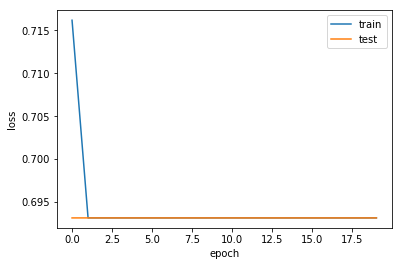

acc:
0.5000593344171188
val_acc:
0.5000000000556533


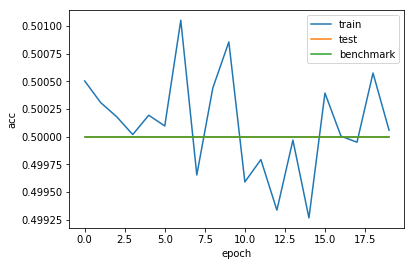

(None, 4, 1)
g_MLP
drop_out
compile model success
13
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2436 MiB, count=89, average=27.4 MiB
[Training model......]
Train on 1084260 samples, validate on 389580 samples
Epoch 1/20
1084260/1084260 [==============================] - 12s 11us/step - loss: 0.7072 - acc: 0.5132 - val_loss: 0.6728 - val_acc: 0.6325
Epoch 2/20
1084260/1084260 [==============================] - 9s 8us/step - loss: 0.6801 - acc: 0.5512 - val_loss: 0.6308 - val_acc: 0.6640
Epoch 3/20
1084260/1084260 [==============================] - 9s 8us/step - loss: 0.6671 - acc: 0.5710 - val_loss: 0.6036 - val_acc: 0.6640
Epoch 4/20
1084260/1084260 [==============================] - 9s 8us/step - loss: 0.6611 - acc: 0.5815 - val_loss: 0.5945 - val_acc: 0.6640
Epoch 5/20
1084260/1084260 [==============================] - 9s 8us/step - loss: 0.6580 - acc: 0.5868 - val_loss: 0.5896 - val_acc: 0.6640
Epoch 6/20
1084260/1084260 [==========================

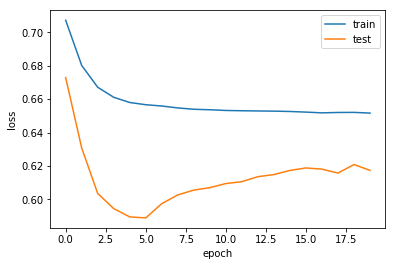

acc:
0.5922592366522121
val_acc:
0.6084860618932456


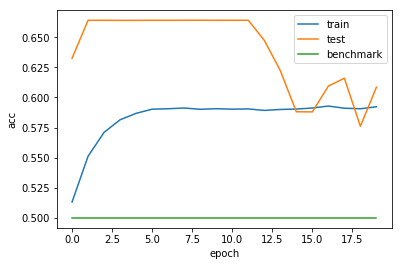

In [10]:
lastepoch_train_acc = []
lastepoch_test_acc = []
lastepoch_train_loss = []
lastepoch_test_loss = []
total_test_vol = []
total_test_trend = []

train_length=3
test_length=1
for i in range(12,14,1):

    MLP_unit=64
    visual_scene = Input((l,currencynum))
    visual_conv = ConvolutionNetworks(20,5)(visual_scene)
    tag = build_tag(visual_conv)
    visual_conv = Concatenate()([visual_conv, tag])
    shapes = visual_conv.shape
    w = shapes[1]
    features= []
    for k1 in range(w):
        def get_feature(t):
            return t[:, k1, :]
        get_feature_layer = Lambda(get_feature)
        features.append(get_feature_layer(visual_conv))

    input2 = Input((16,))
    onehot_encode = input2   

    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode]))    


    g_MLP = get_MLP(5, get_dense(5,MLP_unit))
    f_MLP = get_MLP(5, get_dense(5,MLP_unit))
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))

    combined_relation = Add()(mid_relations)

    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')

    pred = Dense(1, activation = 'sigmoid')(rn)

    model = Model(inputs=[visual_scene, input2, tag], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(i)
    fit_show(Train_data,daynum[i],daynum[i+3],daynum[i+4])

(None, 4, 1)
g_MLP
drop_out
compile model success
13


/opt/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:117: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:116: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2436 MiB, count=91, average=26.8 MiB
[Training model......]
Train on 1084260 samples, validate on 389580 samples
Epoch 1/20
1084260/1084260 [==============================] - 12s 11us/step - loss: 0.7399 - acc: 0.5210 - val_loss: 0.6560 - val_acc: 0.6452
Epoch 2/20
1084260/1084260 [==============================] - 9s 8us/step - loss: 0.6770 - acc: 0.5603 - val_loss: 0.6332 - val_acc: 0.6453
Epoch 3/20
1084260/1084260 [==============================] - 9s 8us/step - loss: 0.6640 - acc: 0.5795 - val_loss: 0.6235 - val_acc: 0.6454
Epoch 4/20
1084260/1084260 [==============================] - 9s 8us/step - loss: 0.6580 - acc: 0.5892 - val_loss: 0.6207 - val_acc: 0.6455
Epoch 5/20
1084260/1084260 [==============================] - 9s 8us/step - loss: 0.6553 - acc: 0.5927 - val_loss: 0.6201 - val_acc: 0.6454
Epoch 6/20
1084260/1084260 [==============================] - 9s 8us/step - loss: 0.6538 - acc: 0.5943 - va

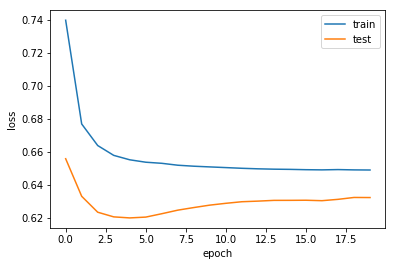

acc:
0.5986829726487954
val_acc:
0.586652292206618


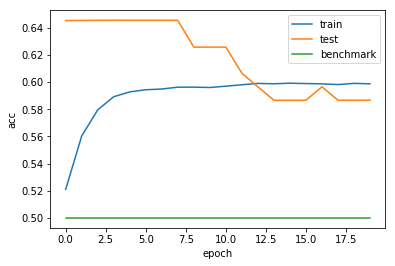

(None, 4, 1)
g_MLP
drop_out
compile model success
14


/opt/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:102: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/opt/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:74: RuntimeWarning: overflow encountered in subtract
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2495 MiB, count=93, average=26.8 MiB
[Training model......]
Train on 1133640 samples, validate on 375840 samples
Epoch 1/20
1133640/1133640 [==============================] - 13s 11us/step - loss: 0.7138 - acc: 0.5265 - val_loss: 0.6547 - val_acc: 0.6557
Epoch 2/20
1133640/1133640 [==============================] - 9s 8us/step - loss: 0.6663 - acc: 0.5803 - val_loss: 0.6408 - val_acc: 0.6594
Epoch 3/20
1133640/1133640 [==============================] - 9s 8us/step - loss: 0.6522 - acc: 0.5988 - val_loss: 0.6431 - val_acc: 0.6498
Epoch 4/20
1133640/1133640 [==============================] - 9s 8us/step - loss: 0.6473 - acc: 0.6026 - val_loss: 0.6437 - val_acc: 0.6403
Epoch 5/20
1133640/1133640 [==============================] - 9s 8us/step - loss: 0.6451 - acc: 0.6036 - val_loss: 0.6444 - val_acc: 0.6395
Epoch 6/20
1133640/1133640 [==============================] - 9s 8us/step - loss: 0.6437 - acc: 0.6045 - va

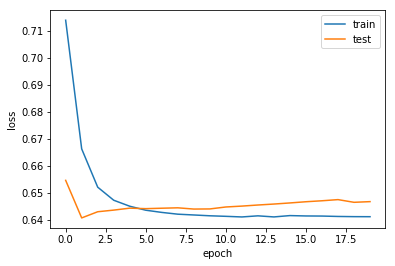

acc:
0.6033105747334887
val_acc:
0.6394875480195927


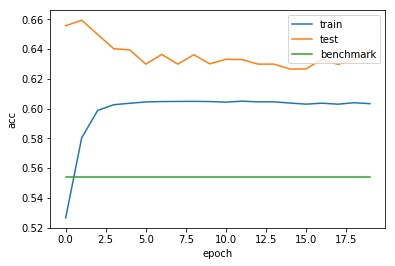

(None, 4, 1)
g_MLP
drop_out
compile model success
15
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2438 MiB, count=94, average=25.9 MiB
[Training model......]
Train on 1116780 samples, validate on 358560 samples
Epoch 1/20
1116780/1116780 [==============================] - 13s 12us/step - loss: 0.7136 - acc: 0.5369 - val_loss: 0.5082 - val_acc: 0.7500
Epoch 2/20
1116780/1116780 [==============================] - 9s 8us/step - loss: 0.6589 - acc: 0.6037 - val_loss: 0.4771 - val_acc: 0.7833
Epoch 3/20
1116780/1116780 [==============================] - 9s 8us/step - loss: 0.6472 - acc: 0.6219 - val_loss: 0.5007 - val_acc: 0.7167
Epoch 4/20
1116780/1116780 [==============================] - 9s 8us/step - loss: 0.6415 - acc: 0.6292 - val_loss: 0.5191 - val_acc: 0.6333
Epoch 5/20
1116780/1116780 [==============================] - 9s 8us/step - loss: 0.6392 - acc: 0.6332 - val_loss: 0.5333 - val_acc: 0.7000
Epoch 6/20
1116780/1116780 [==========================

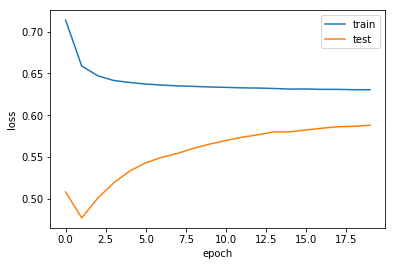

acc:
0.6477614212442613
val_acc:
0.7500000000478753


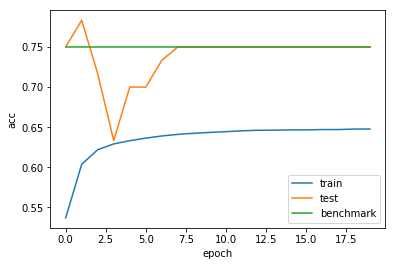

(None, 4, 1)
g_MLP
drop_out
compile model success
16
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2521 MiB, count=95, average=26.5 MiB
[Training model......]
Train on 1132620 samples, validate on 393120 samples
Epoch 1/20
1132620/1132620 [==============================] - 14s 12us/step - loss: 0.5922 - acc: 0.6448 - val_loss: 0.2097 - val_acc: 1.0000
Epoch 2/20
1132620/1132620 [==============================] - 9s 8us/step - loss: 0.5719 - acc: 0.7064 - val_loss: 0.1854 - val_acc: 1.0000
Epoch 3/20
1132620/1132620 [==============================] - 9s 8us/step - loss: 0.5779 - acc: 0.7161 - val_loss: 0.1954 - val_acc: 1.0000
Epoch 4/20
1132620/1132620 [==============================] - 9s 8us/step - loss: 0.5771 - acc: 0.7201 - val_loss: 0.2033 - val_acc: 1.0000
Epoch 5/20
1132620/1132620 [==============================] - 9s 8us/step - loss: 0.5806 - acc: 0.7203 - val_loss: 0.2129 - val_acc: 1.0000
Epoch 6/20
1132620/1132620 [==========================

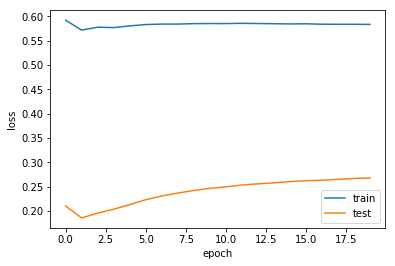

acc:
0.7159373840908739
val_acc:
1.0


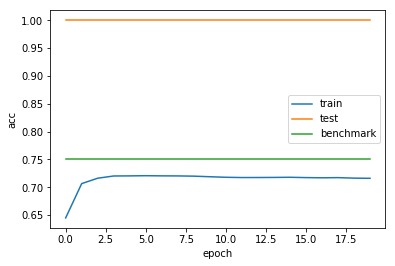

(None, 4, 1)
g_MLP
drop_out
compile model success
17


/opt/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:24: RuntimeWarning: overflow encountered in subtract


/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2476 MiB, count=95, average=26.1 MiB
[Training model......]
Train on 1136160 samples, validate on 362100 samples
Epoch 1/20
1136160/1136160 [==============================] - 14s 12us/step - loss: 0.5825 - acc: 0.7098 - val_loss: 0.1676 - val_acc: 1.0000
Epoch 2/20
1136160/1136160 [==============================] - 9s 8us/step - loss: 0.4014 - acc: 0.8390 - val_loss: 0.0521 - val_acc: 1.0000
Epoch 3/20
1136160/1136160 [==============================] - 9s 8us/step - loss: 0.3970 - acc: 0.8666 - val_loss: 0.0503 - val_acc: 1.0000
Epoch 4/20
1136160/1136160 [==============================] - 9s 8us/step - loss: 0.3951 - acc: 0.8722 - val_loss: 0.0543 - val_acc: 1.0000
Epoch 5/20
1136160/1136160 [==============================] - 9s 8us/step - loss: 0.3936 - acc: 0.8747 - val_loss: 0.0578 - val_acc: 1.0000
Epoch 6/20
1136160/1136160 [==============================] - 9s 8us/step - loss: 0.3918 - acc: 0.8768 - va

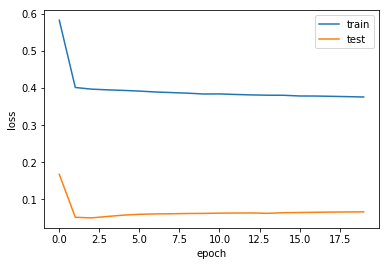

acc:
0.8869340585631529
val_acc:
1.0


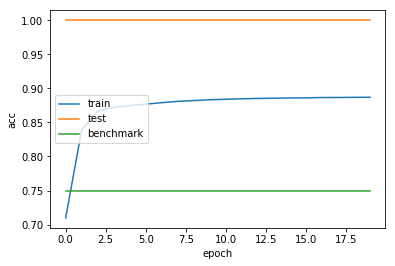

In [11]:
lastepoch_train_acc = []
lastepoch_test_acc = []
lastepoch_train_loss = []
lastepoch_test_loss = []
total_test_vol = []
total_test_trend = []

train_length=3
test_length=1
for i in range(13,18,1):

    MLP_unit=64
    visual_scene = Input((l,currencynum))
    visual_conv = ConvolutionNetworks(20,5)(visual_scene)
    tag = build_tag(visual_conv)
    visual_conv = Concatenate()([visual_conv, tag])
    shapes = visual_conv.shape
    w = shapes[1]
    features= []
    for k1 in range(w):
        def get_feature(t):
            return t[:, k1, :]
        get_feature_layer = Lambda(get_feature)
        features.append(get_feature_layer(visual_conv))

    input2 = Input((16,))
    onehot_encode = input2   

    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode]))    


    g_MLP = get_MLP(5, get_dense(5,MLP_unit))
    f_MLP = get_MLP(5, get_dense(5,MLP_unit))
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))

    combined_relation = Add()(mid_relations)

    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')

    pred = Dense(1, activation = 'sigmoid')(rn)

    model = Model(inputs=[visual_scene, input2, tag], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(i)
    fit_show(Train_data,daynum[i],daynum[i+3],daynum[i+4])

(None, 4, 1)
g_MLP
drop_out
compile model success
12


/opt/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:117: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:116: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2405 MiB, count=95, average=25.3 MiB
[Training model......]
Train on 1112340 samples, validate on 342720 samples
Epoch 1/20
1112340/1112340 [==============================] - 14s 12us/step - loss: 0.7203 - acc: 0.5008 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/20
1112340/1112340 [==============================] - 9s 8us/step - loss: 0.6932 - acc: 0.4990 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 3/20
1112340/1112340 [==============================] - 9s 8us/step - loss: 0.6931 - acc: 0.5004 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 4/20
1112340/1112340 [==============================] - 9s 8us/step - loss: 0.6931 - acc: 0.4995 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 5/20
1112340/1112340 [==============================] - 9s 8us/step - loss: 0.6931 - acc: 0.4993 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 6/20
1112340/1112340 [==============================] - 9s 8us/step - loss: 0.6931 - acc: 0.5004 - va

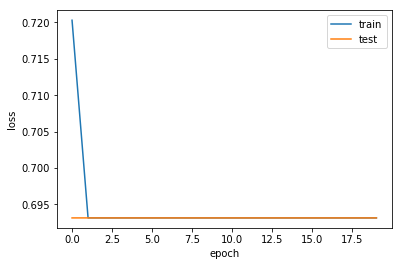

acc:
0.5003515111719955
val_acc:
0.49999999994434674


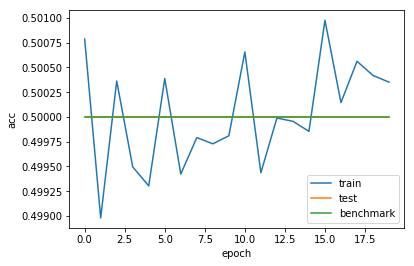

In [12]:
for i in range(12,13,1):

    MLP_unit=64
    visual_scene = Input((l,currencynum))
    visual_conv = ConvolutionNetworks(20,5)(visual_scene)
    tag = build_tag(visual_conv)
    visual_conv = Concatenate()([visual_conv, tag])
    shapes = visual_conv.shape
    w = shapes[1]
    features= []
    for k1 in range(w):
        def get_feature(t):
            return t[:, k1, :]
        get_feature_layer = Lambda(get_feature)
        features.append(get_feature_layer(visual_conv))

    input2 = Input((16,))
    onehot_encode = input2   

    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode]))    


    g_MLP = get_MLP(5, get_dense(5,MLP_unit))
    f_MLP = get_MLP(5, get_dense(5,MLP_unit))
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))

    combined_relation = Add()(mid_relations)

    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')

    pred = Dense(1, activation = 'sigmoid')(rn)

    model = Model(inputs=[visual_scene, input2, tag], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(i)
    fit_show(Train_data,daynum[i],daynum[i+3],daynum[i+4])

(None, 4, 1)
g_MLP
drop_out
compile model success
16


/opt/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:116: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:102: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/opt/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:74: RuntimeWarning: overflow encountered in subtract


/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2521 MiB, count=95, average=26.5 MiB
[Training model......]
Train on 1132620 samples, validate on 393120 samples
Epoch 1/20
1132620/1132620 [==============================] - 14s 13us/step - loss: 0.6014 - acc: 0.6416 - val_loss: 0.2474 - val_acc: 0.9833
Epoch 2/20
1132620/1132620 [==============================] - 9s 8us/step - loss: 0.5693 - acc: 0.6994 - val_loss: 0.1982 - val_acc: 1.0000
Epoch 3/20
1132620/1132620 [==============================] - 9s 8us/step - loss: 0.5748 - acc: 0.7141 - val_loss: 0.2036 - val_acc: 1.0000
Epoch 4/20
1132620/1132620 [==============================] - 10s 9us/step - loss: 0.5767 - acc: 0.7211 - val_loss: 0.2115 - val_acc: 1.0000
Epoch 5/20
1132620/1132620 [==============================] - 9s 8us/step - loss: 0.5785 - acc: 0.7244 - val_loss: 0.2181 - val_acc: 1.0000
Epoch 6/20
1132620/1132620 [==============================] - 9s 8us/step - loss: 0.5784 - acc: 0.7257 - v

/opt/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/opt/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:24: RuntimeWarning: overflow encountered in subtract


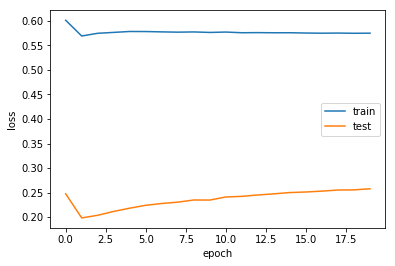

acc:
0.7263345164172474
val_acc:
1.0


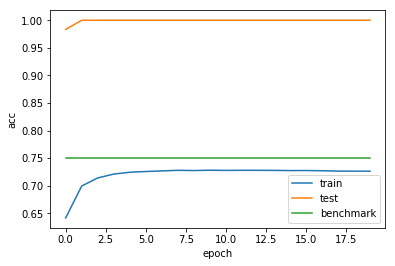

In [13]:
for i in range(16,17,1):

    MLP_unit=64
    visual_scene = Input((l,currencynum))
    visual_conv = ConvolutionNetworks(20,5)(visual_scene)
    tag = build_tag(visual_conv)
    visual_conv = Concatenate()([visual_conv, tag])
    shapes = visual_conv.shape
    w = shapes[1]
    features= []
    for k1 in range(w):
        def get_feature(t):
            return t[:, k1, :]
        get_feature_layer = Lambda(get_feature)
        features.append(get_feature_layer(visual_conv))

    input2 = Input((16,))
    onehot_encode = input2   

    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode]))    


    g_MLP = get_MLP(5, get_dense(5,MLP_unit))
    f_MLP = get_MLP(5, get_dense(5,MLP_unit))
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))

    combined_relation = Add()(mid_relations)

    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')

    pred = Dense(1, activation = 'sigmoid')(rn)

    model = Model(inputs=[visual_scene, input2, tag], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(i)
    fit_show(Train_data,daynum[i],daynum[i+3],daynum[i+4])

(None, 4, 1)
g_MLP
drop_out
compile model success
1


/opt/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:117: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:116: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2443 MiB, count=95, average=25.7 MiB
[Training model......]
Train on 1110360 samples, validate on 367620 samples
Epoch 1/20
1110360/1110360 [==============================] - 15s 13us/step - loss: 0.7868 - acc: 0.4996 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/20
1110360/1110360 [==============================] - 9s 8us/step - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 3/20
1110360/1110360 [==============================] - 9s 8us/step - loss: 0.6932 - acc: 0.4993 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 4/20
1110360/1110360 [==============================] - 9s 8us/step - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 5/20
1110360/1110360 [==============================] - 9s 8us/step - loss: 0.6931 - acc: 0.5001 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 6/20
1110360/1110360 [==============================] - 9s 8us/step - loss: 0.6932 - acc: 0.4993 - va

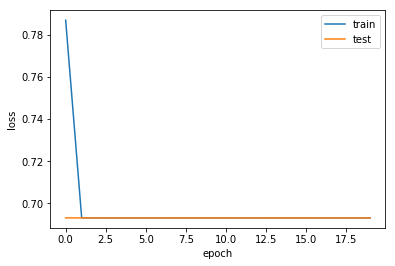

acc:
0.5004250873633491
val_acc:
0.49999999998151645


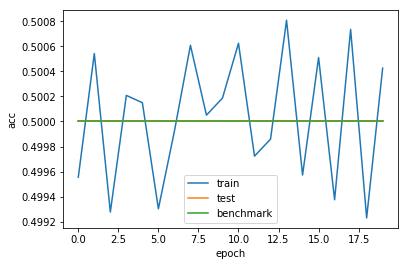

(None, 4, 1)
g_MLP
drop_out
compile model success
2
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2476 MiB, count=95, average=26.1 MiB
[Training model......]
Train on 1125720 samples, validate on 372600 samples
Epoch 1/20
1125720/1125720 [==============================] - 15s 14us/step - loss: 0.7128 - acc: 0.5091 - val_loss: 0.6742 - val_acc: 0.6341
Epoch 2/20
1125720/1125720 [==============================] - 9s 8us/step - loss: 0.6846 - acc: 0.5438 - val_loss: 0.6434 - val_acc: 0.6527
Epoch 3/20
1125720/1125720 [==============================] - 9s 8us/step - loss: 0.6725 - acc: 0.5618 - val_loss: 0.6152 - val_acc: 0.6527
Epoch 4/20
1125720/1125720 [==============================] - 9s 8us/step - loss: 0.6653 - acc: 0.5744 - val_loss: 0.6080 - val_acc: 0.6527
Epoch 5/20
1125720/1125720 [==============================] - 9s 8us/step - loss: 0.6622 - acc: 0.5819 - val_loss: 0.6072 - val_acc: 0.6527
Epoch 6/20
1125720/1125720 [===========================

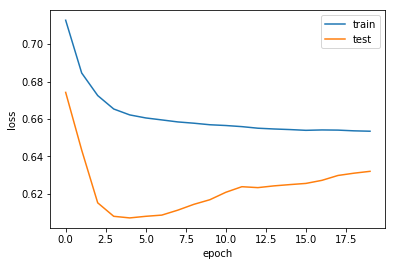

acc:
0.5951248978007997
val_acc:
0.5972034356188403


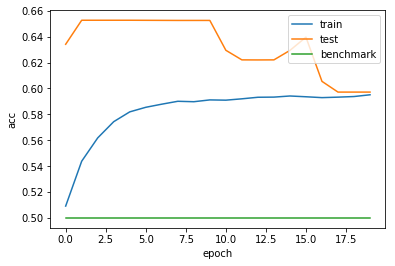

(None, 4, 1)
g_MLP
drop_out
compile model success
3


/opt/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:102: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/opt/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:74: RuntimeWarning: overflow encountered in subtract
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2410 MiB, count=95, average=25.4 MiB
[Training model......]
Train on 1106280 samples, validate on 351720 samples
Epoch 1/20
1106280/1106280 [==============================] - 15s 13us/step - loss: 0.7172 - acc: 0.5239 - val_loss: 0.6628 - val_acc: 0.6504
Epoch 2/20
1106280/1106280 [==============================] - 9s 8us/step - loss: 0.6704 - acc: 0.5748 - val_loss: 0.6242 - val_acc: 0.6551
Epoch 3/20
1106280/1106280 [==============================] - 9s 8us/step - loss: 0.6575 - acc: 0.5922 - val_loss: 0.6184 - val_acc: 0.6500
Epoch 4/20
1106280/1106280 [==============================] - 9s 8us/step - loss: 0.6526 - acc: 0.5963 - val_loss: 0.6177 - val_acc: 0.6468
Epoch 5/20
1106280/1106280 [==============================] - 9s 8us/step - loss: 0.6497 - acc: 0.5986 - val_loss: 0.6173 - val_acc: 0.6418
Epoch 6/20
1106280/1106280 [==============================] - 9s 8us/step - loss: 0.6480 - acc: 0.6004 - va

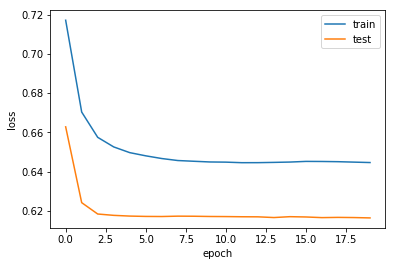

acc:
0.6012022272937144
val_acc:
0.6401484135283717


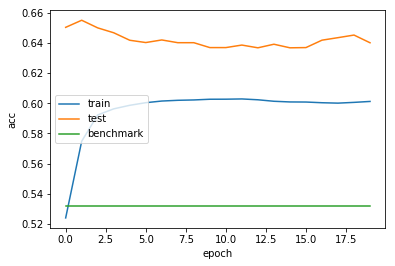

(None, 4, 1)
g_MLP
drop_out
compile model success
4


/opt/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:24: RuntimeWarning: overflow encountered in subtract


/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2447 MiB, count=95, average=25.8 MiB
[Training model......]
Train on 1100580 samples, validate on 380040 samples
Epoch 1/20
1100580/1100580 [==============================] - 15s 14us/step - loss: 0.6883 - acc: 0.5635 - val_loss: 0.5557 - val_acc: 0.6667
Epoch 2/20
1100580/1100580 [==============================] - 9s 8us/step - loss: 0.6508 - acc: 0.6170 - val_loss: 0.5403 - val_acc: 0.6167
Epoch 3/20
1100580/1100580 [==============================] - 9s 8us/step - loss: 0.6431 - acc: 0.6249 - val_loss: 0.5639 - val_acc: 0.5333
Epoch 4/20
1100580/1100580 [==============================] - 9s 8us/step - loss: 0.6397 - acc: 0.6291 - val_loss: 0.5783 - val_acc: 0.5167
Epoch 5/20
1100580/1100580 [==============================] - 9s 8us/step - loss: 0.6379 - acc: 0.6320 - val_loss: 0.5872 - val_acc: 0.5500
Epoch 6/20
1100580/1100580 [==============================] - 9s 8us/step - loss: 0.6361 - acc: 0.6347 - va

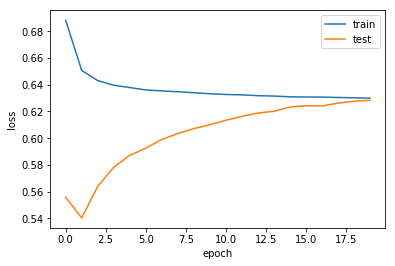

acc:
0.6416862018102433
val_acc:
0.7333333330936851


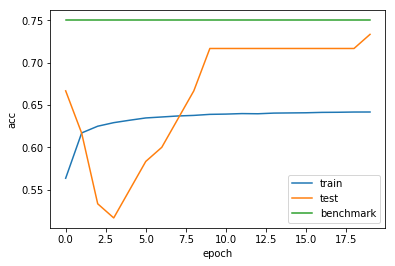

(None, 4, 1)
g_MLP
drop_out
compile model success
5
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2441 MiB, count=95, average=25.7 MiB
[Training model......]
Train on 1113000 samples, validate on 364140 samples
Epoch 1/20
1113000/1113000 [==============================] - 15s 14us/step - loss: 0.6503 - acc: 0.5941 - val_loss: 0.3127 - val_acc: 0.7833
Epoch 2/20
1113000/1113000 [==============================] - 9s 8us/step - loss: 0.5595 - acc: 0.7072 - val_loss: 0.1724 - val_acc: 1.0000
Epoch 3/20
1113000/1113000 [==============================] - 9s 8us/step - loss: 0.5780 - acc: 0.7134 - val_loss: 0.1807 - val_acc: 1.0000
Epoch 4/20
1113000/1113000 [==============================] - 9s 8us/step - loss: 0.5904 - acc: 0.7123 - val_loss: 0.1988 - val_acc: 1.0000
Epoch 5/20
1113000/1113000 [==============================] - 9s 8us/step - loss: 0.5913 - acc: 0.7147 - val_loss: 0.2121 - val_acc: 1.0000
Epoch 6/20
1113000/1113000 [===========================

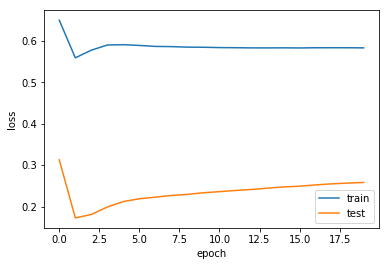

acc:
0.718468104181264
val_acc:
1.0


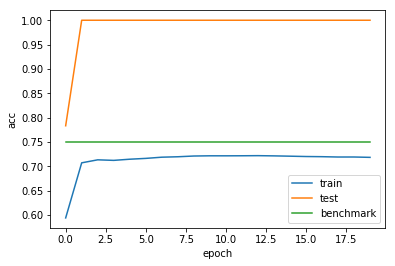

(None, 4, 1)
g_MLP
drop_out
compile model success
6
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2402 MiB, count=95, average=25.3 MiB
[Training model......]
Train on 1104540 samples, validate on 348960 samples
Epoch 1/20
1104540/1104540 [==============================] - 16s 14us/step - loss: 0.5049 - acc: 0.7425 - val_loss: 0.0784 - val_acc: 1.0000
Epoch 2/20
1104540/1104540 [==============================] - 9s 8us/step - loss: 0.3940 - acc: 0.8551 - val_loss: 0.0431 - val_acc: 1.0000
Epoch 3/20
1104540/1104540 [==============================] - 9s 8us/step - loss: 0.3978 - acc: 0.8666 - val_loss: 0.0490 - val_acc: 1.0000
Epoch 4/20
1104540/1104540 [==============================] - 9s 8us/step - loss: 0.3991 - acc: 0.8676 - val_loss: 0.0547 - val_acc: 1.0000
Epoch 5/20
1104540/1104540 [==============================] - 9s 8us/step - loss: 0.4003 - acc: 0.8682 - val_loss: 0.0583 - val_acc: 1.0000
Epoch 6/20
1104540/1104540 [===========================

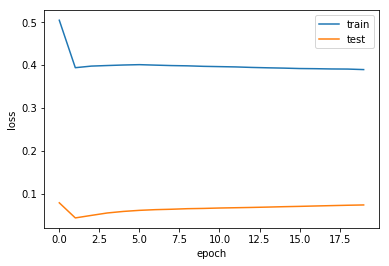

acc:
0.8750909881036449
val_acc:
1.0


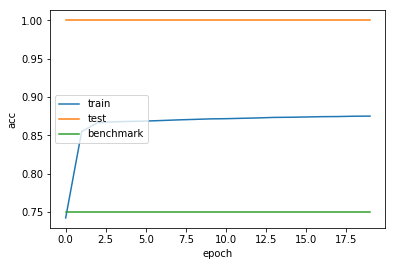

(None, 4, 1)
g_MLP
drop_out
compile model success
7
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2426 MiB, count=95, average=25.5 MiB
[Training model......]
Train on 1101780 samples, validate on 365880 samples
Epoch 1/20
1101780/1101780 [==============================] - 16s 15us/step - loss: 0.4649 - acc: 0.7651 - val_loss: 0.1129 - val_acc: 1.0000
Epoch 2/20
1101780/1101780 [==============================] - 9s 8us/step - loss: 0.0876 - acc: 0.9778 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 3/20
1101780/1101780 [==============================] - 9s 9us/step - loss: 0.0197 - acc: 0.9960 - val_loss: 1.5743e-04 - val_acc: 1.0000
Epoch 4/20
1101780/1101780 [==============================] - 9s 8us/step - loss: 0.0077 - acc: 0.9985 - val_loss: 1.7862e-05 - val_acc: 1.0000
Epoch 5/20
1101780/1101780 [==============================] - 9s 9us/step - loss: 0.0041 - acc: 0.9992 - val_loss: 2.7615e-06 - val_acc: 1.0000
Epoch 6/20
1101780/1101780 [===============

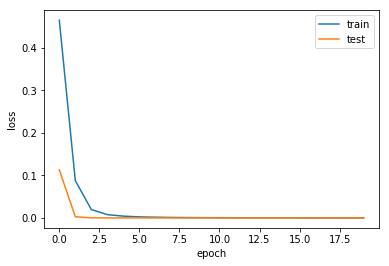

acc:
0.9999827551779847
val_acc:
1.0


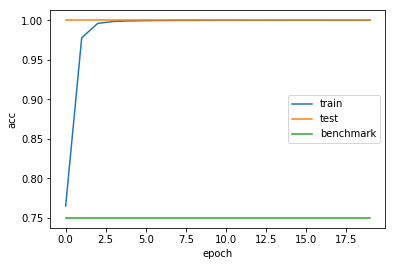

(None, 4, 1)
g_MLP
drop_out
compile model success
8
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2418 MiB, count=95, average=25.5 MiB
[Training model......]
Train on 1087620 samples, validate on 375600 samples
Epoch 1/20
1087620/1087620 [==============================] - 16s 15us/step - loss: 0.6253 - acc: 0.6510 - val_loss: 0.2403 - val_acc: 0.9833
Epoch 2/20
1087620/1087620 [==============================] - 9s 8us/step - loss: 0.1568 - acc: 0.9547 - val_loss: 0.0092 - val_acc: 1.0000
Epoch 3/20
1087620/1087620 [==============================] - 9s 8us/step - loss: 0.0301 - acc: 0.9944 - val_loss: 4.5814e-04 - val_acc: 1.0000
Epoch 4/20
1087620/1087620 [==============================] - 9s 8us/step - loss: 0.0092 - acc: 0.9985 - val_loss: 4.2126e-05 - val_acc: 1.0000
Epoch 5/20
1087620/1087620 [==============================] - 9s 8us/step - loss: 0.0041 - acc: 0.9993 - val_loss: 6.8091e-06 - val_acc: 1.0000
Epoch 6/20
1087620/1087620 [===============

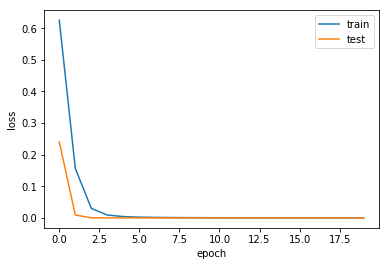

acc:
0.9999705779592137
val_acc:
1.0


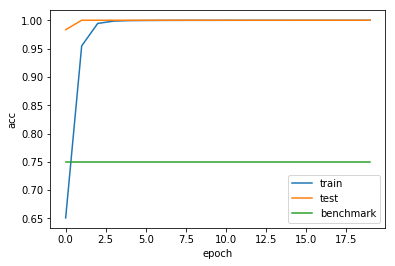

(None, 4, 1)
g_MLP
drop_out
compile model success
9
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2429 MiB, count=95, average=25.6 MiB
[Training model......]
Train on 1099080 samples, validate on 370800 samples
Epoch 1/20
1099080/1099080 [==============================] - 16s 15us/step - loss: 0.5157 - acc: 0.7165 - val_loss: 0.1535 - val_acc: 1.0000
Epoch 2/20
1099080/1099080 [==============================] - 9s 8us/step - loss: 0.0891 - acc: 0.9825 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 3/20
1099080/1099080 [==============================] - 9s 8us/step - loss: 0.0161 - acc: 0.9977 - val_loss: 1.4087e-04 - val_acc: 1.0000
Epoch 4/20
1099080/1099080 [==============================] - 9s 8us/step - loss: 0.0062 - acc: 0.9991 - val_loss: 1.3773e-05 - val_acc: 1.0000
Epoch 5/20
1099080/1099080 [==============================] - 9s 8us/step - loss: 0.0033 - acc: 0.9995 - val_loss: 1.9592e-06 - val_acc: 1.0000
Epoch 6/20
1099080/1099080 [===============

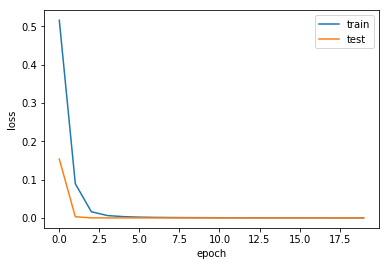

acc:
0.9999781635549733
val_acc:
1.0


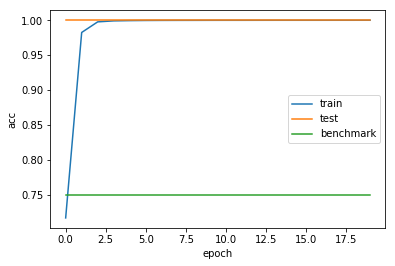

(None, 4, 1)
g_MLP
drop_out
compile model success
10
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=4844 MiB, count=102, average=47.5 MiB
[Training model......]
Train on 1120920 samples, validate on 340200 samples
Epoch 1/20
1120920/1120920 [==============================] - 16s 15us/step - loss: 0.4250 - acc: 0.7839 - val_loss: 0.1267 - val_acc: 1.0000
Epoch 2/20
1120920/1120920 [==============================] - 9s 8us/step - loss: 0.0733 - acc: 0.9853 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 3/20
1120920/1120920 [==============================] - 9s 8us/step - loss: 0.0121 - acc: 0.9981 - val_loss: 9.1388e-05 - val_acc: 1.0000
Epoch 4/20
1120920/1120920 [==============================] - 9s 8us/step - loss: 0.0049 - acc: 0.9992 - val_loss: 9.7467e-06 - val_acc: 1.0000
Epoch 5/20
1120920/1120920 [==============================] - 9s 8us/step - loss: 0.0025 - acc: 0.9996 - val_loss: 1.6034e-06 - val_acc: 1.0000
Epoch 6/20
1120920/1120920 [=============

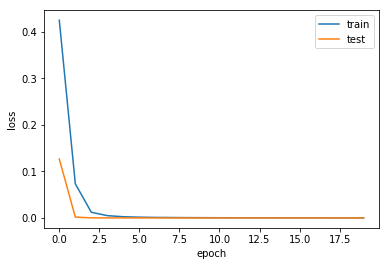

acc:
0.9999714520215537
val_acc:
1.0


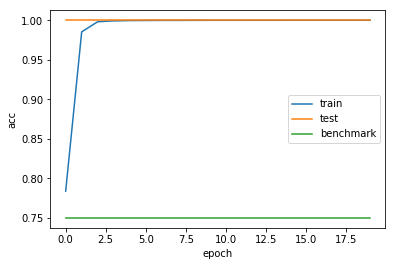

(None, 4, 1)
g_MLP
drop_out
compile model success
11
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2459 MiB, count=95, average=25.9 MiB
[Training model......]
Train on 1095240 samples, validate on 392700 samples
Epoch 1/20
1095240/1095240 [==============================] - 17s 16us/step - loss: 0.5092 - acc: 0.7333 - val_loss: 0.1798 - val_acc: 1.0000
Epoch 2/20
1095240/1095240 [==============================] - 9s 8us/step - loss: 0.1181 - acc: 0.9727 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 3/20
1095240/1095240 [==============================] - 9s 8us/step - loss: 0.0220 - acc: 0.9963 - val_loss: 2.1006e-04 - val_acc: 1.0000
Epoch 4/20
1095240/1095240 [==============================] - 9s 8us/step - loss: 0.0087 - acc: 0.9984 - val_loss: 2.1071e-05 - val_acc: 1.0000
Epoch 5/20
1095240/1095240 [==============================] - 9s 8us/step - loss: 0.0045 - acc: 0.9991 - val_loss: 3.4396e-06 - val_acc: 1.0000
Epoch 6/20
1095240/1095240 [==============

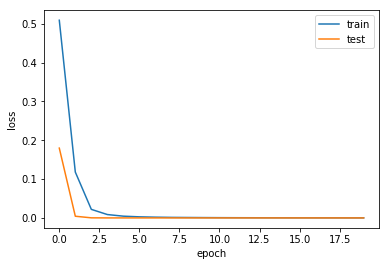

acc:
0.9999707826595085
val_acc:
1.0


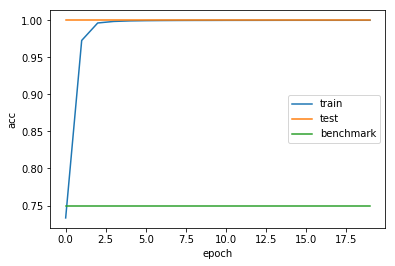

(None, 4, 1)
g_MLP
drop_out
compile model success
12
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=4864 MiB, count=102, average=47.7 MiB
[Training model......]
Train on 1112340 samples, validate on 342720 samples
Epoch 1/20
1112340/1112340 [==============================] - 17s 15us/step - loss: 0.5814 - acc: 0.6829 - val_loss: 0.1288 - val_acc: 1.0000
Epoch 2/20
1112340/1112340 [==============================] - 9s 8us/step - loss: 0.1101 - acc: 0.9766 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 3/20
1112340/1112340 [==============================] - 9s 8us/step - loss: 0.0273 - acc: 0.9943 - val_loss: 1.7625e-04 - val_acc: 1.0000
Epoch 4/20
1112340/1112340 [==============================] - 9s 8us/step - loss: 0.0108 - acc: 0.9977 - val_loss: 1.9399e-05 - val_acc: 1.0000
Epoch 5/20
1112340/1112340 [==============================] - 9s 8us/step - loss: 0.0056 - acc: 0.9987 - val_loss: 3.2574e-06 - val_acc: 1.0000
Epoch 6/20
1112340/1112340 [=============

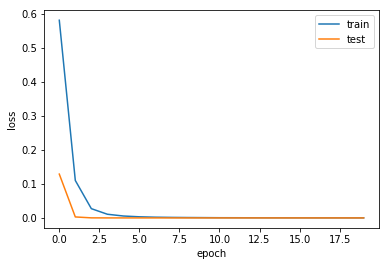

acc:
0.99994066562382
val_acc:
1.0


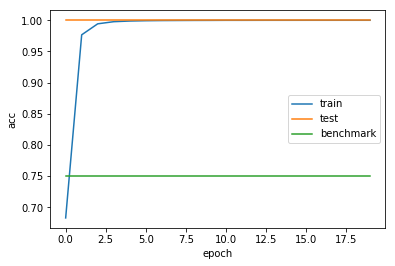

(None, 4, 1)
g_MLP
drop_out
compile model success
13
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=4841 MiB, count=102, average=47.5 MiB
[Training model......]
Train on 1084260 samples, validate on 389580 samples
Epoch 1/20
1084260/1084260 [==============================] - 17s 16us/step - loss: 0.4063 - acc: 0.7958 - val_loss: 0.1020 - val_acc: 1.0000
Epoch 2/20
1084260/1084260 [==============================] - 9s 8us/step - loss: 0.0735 - acc: 0.9820 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 3/20
1084260/1084260 [==============================] - 9s 8us/step - loss: 0.0145 - acc: 0.9973 - val_loss: 1.2421e-04 - val_acc: 1.0000
Epoch 4/20
1084260/1084260 [==============================] - 9s 9us/step - loss: 0.0060 - acc: 0.9988 - val_loss: 1.5560e-05 - val_acc: 1.0000
Epoch 5/20
1084260/1084260 [==============================] - 9s 8us/step - loss: 0.0033 - acc: 0.9993 - val_loss: 2.9505e-06 - val_acc: 1.0000
Epoch 6/20
1084260/1084260 [=============

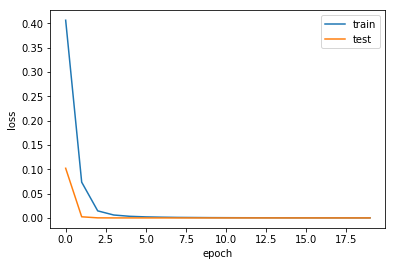

acc:
0.9999806319517459
val_acc:
1.0


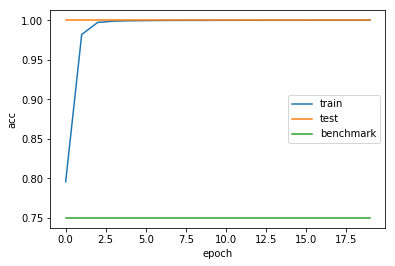

(None, 4, 1)
g_MLP
drop_out
compile model success
14


/opt/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in subtract


/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2495 MiB, count=95, average=26.3 MiB
[Training model......]
Train on 1133640 samples, validate on 375840 samples
Epoch 1/20
1133640/1133640 [==============================] - 18s 16us/step - loss: 0.4221 - acc: 0.8111 - val_loss: 0.2197 - val_acc: 0.9126
Epoch 2/20
1133640/1133640 [==============================] - 9s 8us/step - loss: 0.0733 - acc: 0.9818 - val_loss: 0.4814 - val_acc: 0.9126
Epoch 3/20
1133640/1133640 [==============================] - 9s 8us/step - loss: 0.0192 - acc: 0.9952 - val_loss: 0.7673 - val_acc: 0.9126
Epoch 4/20
1133640/1133640 [==============================] - 9s 8us/step - loss: 0.0079 - acc: 0.9980 - val_loss: 0.9916 - val_acc: 0.9126
Epoch 5/20
1133640/1133640 [==============================] - 9s 8us/step - loss: 0.0043 - acc: 0.9989 - val_loss: 1.1896 - val_acc: 0.9126
Epoch 6/20
1133640/1133640 [==============================] - 9s 8us/step - loss: 0.0027 - acc: 0.9993 - va

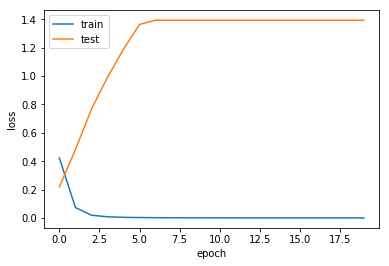

acc:
0.9999691260011997
val_acc:
0.9125638568284614


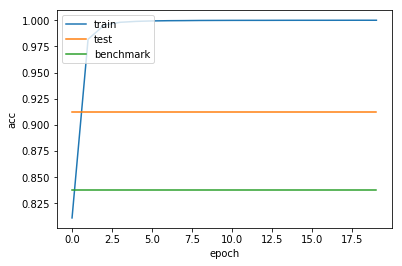

(None, 4, 1)
g_MLP
drop_out
compile model success
15
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=4933 MiB, count=102, average=48.4 MiB
[Training model......]
Train on 1116780 samples, validate on 358560 samples
Epoch 1/20
1116780/1116780 [==============================] - 18s 16us/step - loss: 0.5153 - acc: 0.7287 - val_loss: 0.0951 - val_acc: 0.9861
Epoch 2/20
1116780/1116780 [==============================] - 9s 8us/step - loss: 0.2238 - acc: 0.9021 - val_loss: 0.0768 - val_acc: 0.9861
Epoch 3/20
1116780/1116780 [==============================] - 9s 8us/step - loss: 0.1485 - acc: 0.9483 - val_loss: 0.2190 - val_acc: 0.8380
Epoch 4/20
1116780/1116780 [==============================] - 9s 8us/step - loss: 0.1247 - acc: 0.9598 - val_loss: 0.3229 - val_acc: 0.7639
Epoch 5/20
1116780/1116780 [==============================] - 10s 9us/step - loss: 0.1164 - acc: 0.9662 - val_loss: 0.3413 - val_acc: 0.7639
Epoch 6/20
1116780/1116780 [========================

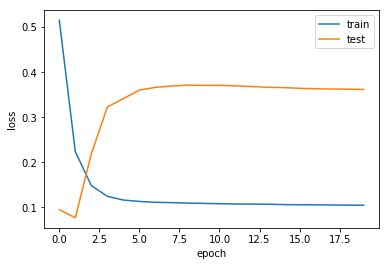

acc:
0.9704006160338211
val_acc:
0.7638888890005977


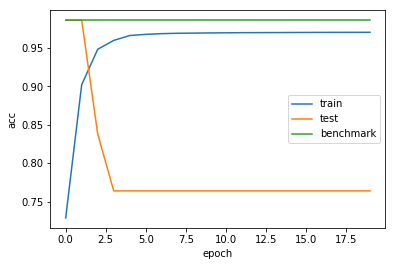

(None, 4, 1)
g_MLP
drop_out
compile model success
16
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2521 MiB, count=95, average=26.5 MiB
[Training model......]
Train on 1132620 samples, validate on 393120 samples
Epoch 1/20
1132620/1132620 [==============================] - 19s 17us/step - loss: 0.3598 - acc: 0.8200 - val_loss: 0.0575 - val_acc: 0.9861
Epoch 2/20
1132620/1132620 [==============================] - 10s 9us/step - loss: 0.2119 - acc: 0.9173 - val_loss: 0.0554 - val_acc: 0.9861
Epoch 3/20
1132620/1132620 [==============================] - 10s 8us/step - loss: 0.1688 - acc: 0.9368 - val_loss: 0.0550 - val_acc: 0.9861
Epoch 4/20
1132620/1132620 [==============================] - 10s 9us/step - loss: 0.1673 - acc: 0.9332 - val_loss: 0.0547 - val_acc: 0.9861
Epoch 5/20
1132620/1132620 [==============================] - 10s 8us/step - loss: 0.1736 - acc: 0.9234 - val_loss: 0.0556 - val_acc: 0.9861
Epoch 6/20
1132620/1132620 [======================

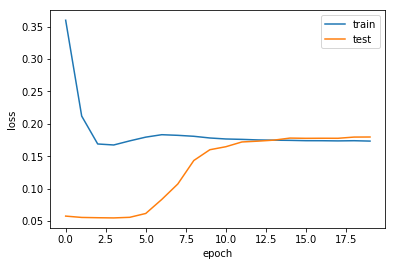

acc:
0.8888709363689239
val_acc:
0.7638888887918525


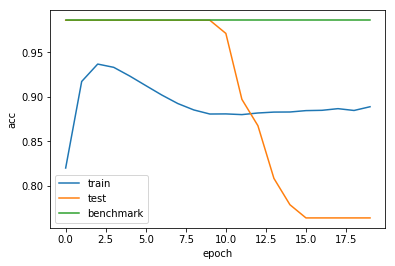

(None, 4, 1)
g_MLP
drop_out
compile model success
17
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=4998 MiB, count=102, average=49.0 MiB
[Training model......]
Train on 1136160 samples, validate on 362100 samples
Epoch 1/20
1136160/1136160 [==============================] - 19s 17us/step - loss: 0.3504 - acc: 0.8483 - val_loss: 0.0716 - val_acc: 0.9861
Epoch 2/20
1136160/1136160 [==============================] - 9s 8us/step - loss: 0.2617 - acc: 0.9307 - val_loss: 0.0623 - val_acc: 0.9861
Epoch 3/20
1136160/1136160 [==============================] - 9s 8us/step - loss: 0.2239 - acc: 0.9342 - val_loss: 0.0575 - val_acc: 0.9861
Epoch 4/20
1136160/1136160 [==============================] - 9s 8us/step - loss: 0.1922 - acc: 0.9350 - val_loss: 0.0557 - val_acc: 0.9861
Epoch 5/20
1136160/1136160 [==============================] - 10s 8us/step - loss: 0.1737 - acc: 0.9350 - val_loss: 0.0555 - val_acc: 0.9861
Epoch 6/20
1136160/1136160 [========================

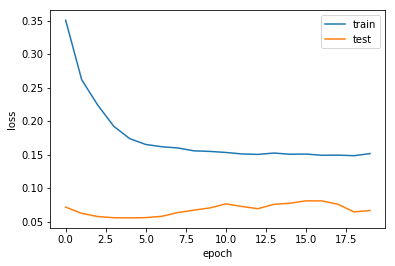

acc:
0.9368926911702578
val_acc:
0.9860811930386212


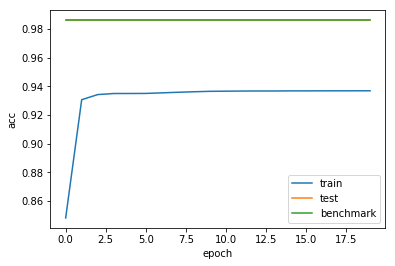

(None, 4, 1)
g_MLP
drop_out
compile model success
18
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2470 MiB, count=95, average=26.0 MiB
[Training model......]
Train on 1122420 samples, validate on 372300 samples
Epoch 1/20
1122420/1122420 [==============================] - 19s 17us/step - loss: 0.1942 - acc: 0.9492 - val_loss: 0.0678 - val_acc: 0.9861
Epoch 2/20
1122420/1122420 [==============================] - 10s 9us/step - loss: 0.0856 - acc: 0.9847 - val_loss: 0.0562 - val_acc: 0.9861
Epoch 3/20
1122420/1122420 [==============================] - 10s 9us/step - loss: 0.0689 - acc: 0.9858 - val_loss: 0.0545 - val_acc: 0.9861
Epoch 4/20
1122420/1122420 [==============================] - 9s 8us/step - loss: 0.0633 - acc: 0.9860 - val_loss: 0.0545 - val_acc: 0.9861
Epoch 5/20
1122420/1122420 [==============================] - 10s 9us/step - loss: 0.0614 - acc: 0.9861 - val_loss: 0.0547 - val_acc: 0.9861
Epoch 6/20
1122420/1122420 [=======================

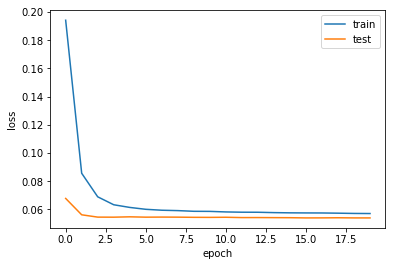

acc:
0.9861014593467686
val_acc:
0.98614020960452


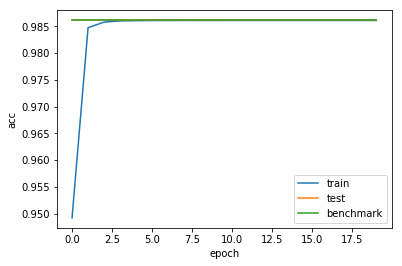

(None, 4, 1)
g_MLP
drop_out
compile model success
19
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=4967 MiB, count=102, average=48.7 MiB
[Training model......]
Train on 1136160 samples, validate on 374700 samples
Epoch 1/20
1136160/1136160 [==============================] - 19s 17us/step - loss: 0.2432 - acc: 0.9255 - val_loss: 0.0740 - val_acc: 0.9861
Epoch 2/20
1136160/1136160 [==============================] - 10s 8us/step - loss: 0.0995 - acc: 0.9831 - val_loss: 0.0631 - val_acc: 0.9861
Epoch 3/20
1136160/1136160 [==============================] - 10s 8us/step - loss: 0.0775 - acc: 0.9852 - val_loss: 0.0555 - val_acc: 0.9861
Epoch 4/20
1136160/1136160 [==============================] - 9s 8us/step - loss: 0.0669 - acc: 0.9858 - val_loss: 0.0541 - val_acc: 0.9861
Epoch 5/20
1136160/1136160 [==============================] - 10s 9us/step - loss: 0.0632 - acc: 0.9860 - val_loss: 0.0539 - val_acc: 0.9861
Epoch 6/20
1136160/1136160 [======================

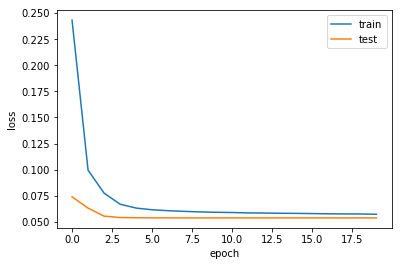

acc:
0.9861111111111112
val_acc:
0.9860688551216085


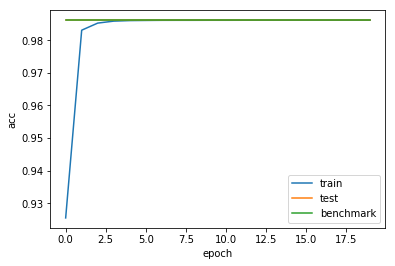

In [14]:
for i in range(1,20,1):

    MLP_unit=64
    visual_scene = Input((l,currencynum))
    visual_conv = ConvolutionNetworks(20,5)(visual_scene)
    tag = build_tag(visual_conv)
    visual_conv = Concatenate()([visual_conv, tag])
    shapes = visual_conv.shape
    w = shapes[1]
    features= []
    for k1 in range(w):
        def get_feature(t):
            return t[:, k1, :]
        get_feature_layer = Lambda(get_feature)
        features.append(get_feature_layer(visual_conv))

    input2 = Input((16,))
    onehot_encode = input2   

    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode]))    


    g_MLP = get_MLP(5, get_dense(5,MLP_unit))
    f_MLP = get_MLP(5, get_dense(5,MLP_unit))
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))

    combined_relation = Add()(mid_relations)

    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')

    pred = Dense(1, activation = 'sigmoid')(rn)

    model = Model(inputs=[visual_scene, input2, tag], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(i)
    fit_show(Train_data,daynum[i],daynum[i+3],daynum[i+4])

train_acc:red,test_acc:blue


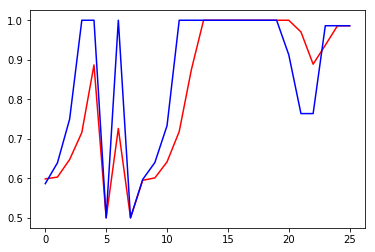

train_loss:red,test_loss:blue


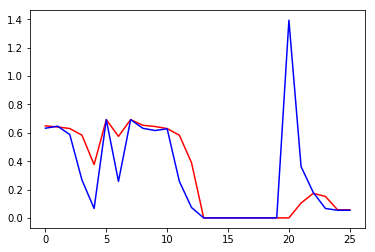

trend:red,vol:blue


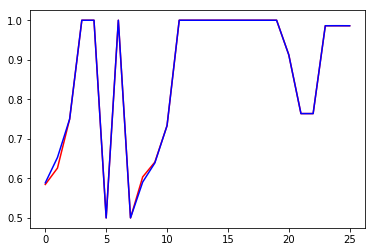

In [15]:
print("train_acc:red,test_acc:blue")    
plt.plot(lastepoch_train_acc,color='r')
plt.plot(lastepoch_test_acc,color='b')
plt.show()
print("train_loss:red,test_loss:blue")
plt.plot(lastepoch_train_loss,color='r')
plt.plot(lastepoch_test_loss,color='b')
plt.show()
print("trend:red,vol:blue")
plt.plot(total_test_trend,color='r')
plt.plot(total_test_vol,color='b')
plt.show()